# Metaheurística e quantidade de conhecimento a priori utilizado para gerar a população inicia

Neste notebook apresentamos a comparação do nível de conhecimento *a priori* necessário para os seguintes algoritmos de busca e otimização:
- **RW**: Randon Walk
- **MC**: Método de Monte Carlo
- **MCTS**: Tree Search com método Monte Carlo
- **SA**: Simulated Annealing
- **GA**: Genetic Algorithm (usando DEAP)
- **DE**: Differential Evolution (usando SciPy)

## Bibliotecas Utilizadas

In [1]:
import time # Para uso na medida de tempo de execução
import numpy as np # Uso geral de funções matemáticas e arrays
import matplotlib.pyplot as plt # Para Plotagem de gráficos em geral

from deap import base, creator, tools, algorithms
from scipy.optimize import differential_evolution
import pandas as pd
import seaborn as sns

## Função Trap

In [2]:
def trap_k(u: int, k: int) -> int:
    """
    Função trap de ordem k aplicada ao número de uns 'u' em um bloco.
    """
    return k if u == k else k - 1 - u

def f_k(x: np.ndarray, k: int) -> int:
    """
    Avalia f_k em um vetor binário x de tamanho n, onde n % k == 0.
    """
    n = x.size
    m = n // k
    total = 0
    for i in range(m):
        # soma de uns no bloco i
        u = x[i*k : (i+1)*k].sum()
        total += trap_k(int(u), k)
    return total

## Funções de geração de sequências pseudo-aleatórias

In [3]:
def fill_ones_up_to(x: np.ndarray, level: int):
    pos = max(0, min(level, len(x) - 1))
    x[:pos] = 1
    
def generate_item(chromo_size: int, p: int = 0)->np.ndarray:
    x = np.random.randint(0, 2, size=chromo_size)
    fill_ones_up_to(x, p)
    return x

def generate_list(chromo_size: int, pop_size: int, p: int = 0)->list[np.ndarray]:
    result: list[np.ndarray] = []
    for _ in range(pop_size):
        x = generate_item(chromo_size, p)
        result.append(x)
    return result

In [4]:
K=4
M=6
N=K*M
for p in range(0, M):
    print(f"g[{p}]={generate_item(N, p*K)}")

g[0]=[0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1]
g[1]=[1 1 1 1 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 1]
g[2]=[1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 0]
g[3]=[1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0]
g[4]=[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0]
g[5]=[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1]


# Metaheurísticas

## Randon Search ou Randon Walk

O *Random Search* é uma metaheurística extremamente simples que explora o espaço de soluções pela aplicação de pequenas perturbações aleatórias. No contexto de $\mathrm{trap}_k$, ela:

1. Mantém uma **solução corrente**.
2. Em cada iteração, **flipa** um bit escolhido aleatoriamente (com opção de respeitar um "nível prévio" de conhecimento fixando alguns bits).
3. Avalia a nova solução e, se for melhor, **atualiza** o melhor registro.
4. Repete até um número fixo de iterações, colecionando o histórico dos melhores valores encontrados.

In [5]:
def random_search(
    n: int,             # comprimento do vetor binário
    k: int,             # tamanho do bloco para avaliação f_k
    priori_level = 0,   # quantidade de blocos já "conhecidos" (bits iniciais fixos)
    iterations = 10000, # número total de flips 
    seed: int = None    # semente para reproducibilidade
    )-> tuple[np.ndarray, int, list[int]]:
    
    # 1. Inicialização aleatória (se desejada, fixa seed)
    if seed is not None:
        np.random.seed(seed)

    # 2. Calcula quantos bits fixos: p = k * priori_level
    p = k * priori_level
        
    # 3. Gera solução inicial com p uns "pré-fixados"
    x = generate_item(n, p)
    
    best_value = f_k(x, k)
    best_x = x.copy()
    history = [best_value]
    
    # 4. Loop principal: sorteia e flipa um bit em cada iteração
    for _ in range(1, iterations + 1):
        # escolhe índice para flip
        i = np.random.randint(p, n) # escolhe índice entre p e n–1
        x[i] ^= 1  # inverte o bit em i
        
        value = f_k(x, k) # avalia novo vetor

        # 5. Atualiza melhor se a nova for superior
        if value > best_value:
            best_value = value
            best_x = x.copy()

        history.append(best_value)

    # Retorna (melhor solução, valor, histórico de fitness)
    return best_x, best_value, history

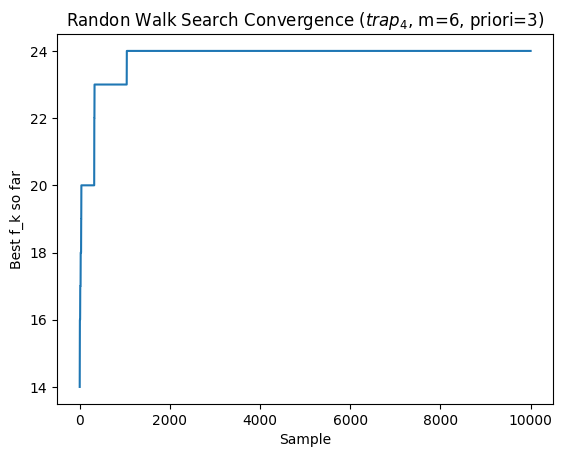

Best Value: 24
Best Solution: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Runtime: 0.491194 s


In [6]:
# Parameters
K=4
M=6
N=K*M
PRIORI = 3

# Running
start = time.perf_counter()
best_solution, best_score, hist = random_search(N, K, priori_level=PRIORI, seed=42)
end = time.perf_counter()

# Plot convergence
plt.figure()
plt.plot(hist)
plt.xlabel("Sample")
plt.ylabel("Best f_k so far")
plt.title(f"Randon Walk Search Convergence ($trap_{K}$, m={M}, priori={PRIORI})")
plt.show()

# Print results
print(f"Best Value: {best_score}")
print(f"Best Solution: {best_solution}")
print(f"Runtime: {end - start:.6f} s")

## Simulated Annealing

O *Simulated Annealing* é uma meta­heurística inspirada no processo de recozimento em metais. Ela explora o espaço de soluções permitindo, em estágios iniciais (alta temperatura), aceitar movimentos que pioram a função-objetivo — facilitando a fuga de ótimos locais — e, gradualmente, abaixa a temperatura, reduzindo essa probabilidade até convergir.


In [7]:
def simulated_annealing(
    n: int,                # comprimento do vetor binário
    k: int,                # tamanho do bloco para f_k
    priori_level=0,        # quantos blocos já “conhecidos” (bits fixos no início)
    initial_temp=10.0,     # temperatura inicial
    final_temp=0.1,        # temperatura mínima de parada
    alpha=0.95,            # taxa de resfriamento (0 < alpha < 1)
    num_iterations=200,    # iterações por temperatura
    seed=None              # semente para reproducibilidade
    )-> tuple[np.ndarray, int, list[int]]:
    
    # 1. Configura semente (se fornecida)
    if seed is not None:
        np.random.seed(seed)
    
    # 2. Quantos bits ficam imunes a flips: p = k * priori_level
    p = k * priori_level
    
    # 3. Solução inicial e avaliação
    x = generate_item(n, p)
    
    current_value = f_k(x, k)
    
    best_x = x.copy()
    best_value = current_value
    
    # 4. Inicializa temperatura e histórico
    temp = initial_temp
    history = [best_value]
    
    # 5. Processo de resfriamento
    while temp > final_temp:
        for _ in range(num_iterations):
            # 5.1 Gera candidato por flip de um bit idx ≥ p
            candidate = x.copy()
            idx = np.random.randint(p, n)
            candidate[idx] = 1 - candidate[idx]
            
            # 5.2 Avalia e decide aceitação
            candidate_value = f_k(candidate, k)
            delta = candidate_value - current_value
            # controla a probabilidade de aceitar soluções piores via critério de Metropolis
            if delta > 0 or np.random.rand() < np.exp(delta / temp):
                x = candidate
                current_value = candidate_value                
                # 5.3 Atualiza melhor global
                if current_value > best_value:
                    best_value = current_value
                    best_x = x.copy()
            
            history.append(best_value)
        
        # 5.4 Reduz temperatura
        temp *= alpha
    
    # Retorna (melhor solução, valor, histórico)
    return best_x, best_value, history

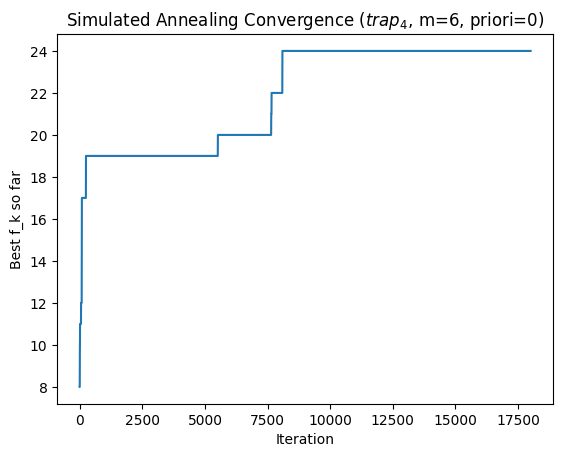

Best Value: 24
Best Solution: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Runtime: 0.897563 s


In [8]:
# Parameters
K=4
M=6
N=K*M
PRIORI = 0

# Running
start = time.perf_counter()
best_solution, best_score, hist = simulated_annealing(N, K, priori_level=PRIORI, seed=42)
end = time.perf_counter()

# Plot convergence
plt.figure()
plt.plot(hist)
plt.xlabel("Iteration")
plt.ylabel("Best f_k so far")
plt.title(f"Simulated Annealing Convergence ($trap_{K}$, m={M}, priori={PRIORI})")
plt.show()

# Print results
print(f"Best Value: {best_score}")
print(f"Best Solution: {best_solution}")
print(f"Runtime: {end - start:.6f} s")

## Método Monte Carlo

O *Método Monte Carlo* explora o espaço de soluções amostrando aleatoriamente um conjunto de candidatos independentes e mantendo aquele com melhor avaliação. É uma linha de base simples que, sem operadores locais ou memória de movimentos anteriores, confia na quantidade de amostras para encontrar boas soluções.


In [9]:
def monte_carlo_search(
    n: int,              # comprimento do vetor binário
    k: int,              # tamanho do bloco para f_k
    priori_level=0,      # quantos blocos já “conhecidos” (bits fixos no início)
    num_samples=10000,   # número total de amostras aleatórias
    seed=None            # semente para reproducibilidade
    )-> tuple[np.ndarray, int, list[int]]:
    
    # 1. Controla gerador aleatório
    if seed is not None:
        np.random.seed(seed)
    
    # 2. Inicializa melhor valor e histórico
    best_value = -np.inf
    best_x = None
    history = []
    
    # 3. Calcula quantos bits ficam imunes a flips
    p = k * priori_level
    
    # 4. Amostragem independente
    for _ in range(1, num_samples + 1):
        x = generate_item(n, p)  # nova solução aleatória
        value = f_k(x, k)        # avalia f_k
        if value > best_value:
            best_value = value
            best_x = x.copy()
        history.append(best_value)
    
    # Retorna (melhor solução, valor, histórico de melhores)
    return best_x, best_value, history

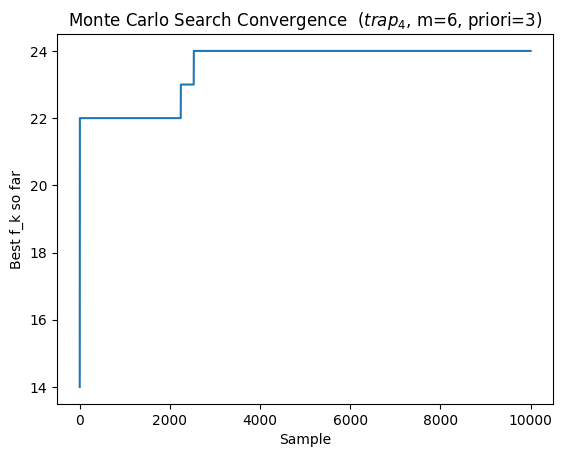

Best Value: 24
Best Solution: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Runtime: 0.633464 s


In [10]:
# Parameters
K=4
M=6
N=K*M
PRIORI = 3

# Running
start = time.perf_counter()
best_solution, best_score, hist = monte_carlo_search(N, K, priori_level=PRIORI, seed=42)
end = time.perf_counter()

# Plot convergence
plt.figure()
plt.plot(hist)
plt.xlabel("Sample")
plt.ylabel("Best f_k so far")
plt.title(f"Monte Carlo Search Convergence  ($trap_{K}$, m={M}, priori={PRIORI})")
plt.show()

# Print results
print(f"Best Value: {best_score}")
print(f"Best Solution: {best_solution}")
print(f"Runtime: {end - start:.6f} s")

## Monte Carlo Tree Search

O *Monte Carlo Tree Search (MCTS)* constrói iterativamente uma árvore de decisões em quatro fases principais:

1. `Seleção`: navega da raiz até um nó folha, escolhendo em cada passo o filho que maximiza a pontuação UCT (equilíbrio entre exploração e exploração).

2. `Expansão`: quando encontra um nó não totalmente expandido, cria um novo filho para uma ação ainda não explorada.

3. `Simulação` (ou Rollout): a partir desse novo nó, completa aleatoriamente o resto da solução até a profundidade $m$, somando os valores de *trap_k*.

4. `Backpropagation`: propaga o retorno calculado de volta até a raiz, atualizando os contadores de visitas e valores acumulados.

No contexto de $\mathrm{trap}_k$, cada nível da árvore corresponde a um bloco de $k$ bits, e cada ação $u\in\{0,\dots,k\}$ escolhe quantos bits "1" serão usados naquele bloco.


In [11]:
# MCTS ajustado para trap_k com retorno de histórico
class MCTSNode:
    def __init__(self, depth, parent=None):
        self.depth   = depth      # profundidade (quantos blocos já escolheram)
        self.parent  = parent     # nó pai (None no root)
        self.children= {}         # dicionário move → MCTSNode
        self.visits  = 0          # número de simulações que passaram por aqui
        self.value   = 0.0        # soma dos retornos acumulados
        self.choice  = None       # a ação (u em 0..k) que levou a este nó

    def is_fully_expanded(self, k):
        # retorna True se já criamos filhos para todas as k+1 escolhas possíveis
        return len(self.children) == (k + 1)

    def uct_score(self, total_simulations, c=1.0):
        # Upper-Confidence bound applied to Trees
        # Se ainda não foi visitado, força exploração
        if self.visits == 0:
            return np.inf
        # Exploração (value/visits) + Exploração (c * sqrt(log N_parent / visits))
        return (self.value / self.visits) + c * np.sqrt(np.log(total_simulations) / self.visits)

def rollout_reward(node, m, k, priori_level):
    total = 0
    cur = node
    # 1) retorno até a raiz: soma trap_k(choice, k) dos nós já escolhidos
    while cur.parent:
        total += trap_k(cur.choice, k)
        cur = cur.parent
    # 2) do nível atual até m: escolhas aleatórias
    for depth  in range(cur.depth, m):
        if depth < priori_level:
            u = k        # prioriza bloco completo de 1s
        else:
            u = np.random.randint(0, k+1)
        total += trap_k(u, k)
    return total

def monte_carlo_tree_search(
    n: int,                # tamanho total do vetor (n = m*k)
    k: int,                # tamanho de cada bloco
    priori_level=0,        # primeiros níveis forçam ação u = k
    iterations=10000,      # número total de iterações MCTS
    c=1.0,                 # parâmetro de exploração/exploração em UCT
    seed=None              # semente para reproducibilidade
    )-> tuple[np.ndarray, int, list[int]]:
    if seed is not None:
        np.random.seed(seed)
        
    m = n // k
    
    root = MCTSNode(depth=0)
    history = []
    best_value = -np.inf
    best_solution = None

    for _ in range(iterations):
        node = root
        # 1. Seleção: desce escoltando UCT até um nó não expandido ou folha
        while node.depth < m and node.is_fully_expanded(k):
            scores = {u: child.uct_score(node.visits, c) for u, child in node.children.items()}
            choice = max(scores, key=scores.get)
            node = node.children[choice]
        
        # 2. Expansão: cria um novo filho para uma ação não tentada
        if node.depth < m:
            untried = [u for u in range(k+1) if u not in node.children]
            choice = k if node.depth < priori_level else np.random.choice(untried)
            child = MCTSNode(depth=node.depth+1, parent=node)
            child.choice = choice
            node.children[choice] = child
            node = child
            
        # 3. Simulação: completa aleatoriamente do nível atual até m
        reward = rollout_reward(node, m, k, priori_level)
        
        # 4. Backpropagation: atualiza visitas e valores até a raiz
        cur = node
        while cur:
            cur.visits += 1
            cur.value += reward
            cur = cur.parent
            
        # Reconstrói solução a partir da raiz seguindo a melhor média valor/visita
        sol = []
        cur = root        
        depth = 0
        # percorre árvore guiada onde houver filhos
        while depth < m and cur.children:
            best_u = max(cur.children,
                         key=lambda u: cur.children[u].value / cur.children[u].visits)
            block = [1]*best_u + [0]*(k-best_u)
            np.random.shuffle(block)
            sol.extend(block)
            cur = cur.children[best_u]
            depth += 1
        # rollout puro para níveis restantes
        for d in range(depth, m):
            u = k if d < priori_level else np.random.randint(0, k+1)
            block = [1]*u + [0]*(k-u)
            np.random.shuffle(block)
            sol.extend(block)
        
        # avalia o vetor inteiro blocos-a-bloco
        score = f_k(np.array(sol), k)
        
        # mantém o melhor global
        if score > best_value:
            best_value = score
            best_solution = sol.copy()
        history.append(best_value)

    # Retorna (melhor solução, valor, histórico de melhores)
    return best_solution, best_value, history

MCTS para $\mathrm{trap}_k$: Etapas Detalhadas:

### 1. Seleção

- **Objetivo**: navegar da raiz até um nó folha "promissor".  
- **Critério**: em cada nó $v$, seleciona-se a ação $u$ que maximiza a pontuação UCT:
  $$
    \mathrm{UCT}(v,u) \;=\; \frac{Q(v,u)}{N(v,u)} \;+\; c\,\sqrt{\frac{\ln N(v)}{N(v,u)}},
  $$
  onde  
  - $Q(v,u)$ é o valor acumulado do filho pela ação $u$,  
  - $N(v,u)$ é o número de visitas desse filho,  
  - $N(v)$ é o número de visitas do nó pai,  
  - $c>0$ equilibra exploração versus exploração.  
- **Condição de parada**: para de descer quando chega a um nó ainda não totalmente expandido ou atinge a profundidade máxima $m = n/k$.

### 2. Expansão

- **Quando**: ao chegar num nó $v$ que não tem filhos para todas as ações possíveis $u\in\{0,\dots,k\}$.  
- **Como**:
  1. Lista-se o conjunto de ações não testadas em $v$.  
  2. Se $v$.depth < priori_level, força-se a ação $u=k$ (bloco cheio de 1s) para incorporar conhecimento prévio.  
  3. Caso contrário, escolhe-se aleatoriamente uma das ações não experimentadas.  
  4. Cria-se um novo nó filho $v'$ para essa ação, registrando sua profundidade e a ação que o originou.

### 3. Simulação (Rollout)

- **Objetivo**: estimar a qualidade de expandir nesse nó sem construir toda a árvore.  
- **Procedimento**:
  1. **Recontagem do caminho**: soma-se, para cada ancestral do nó atual, o valor $\mathrm{trap}_k(u)$ da ação $u$ que gerou esse nó.  
  2. **Completar aleatoriamente**: para cada bloco ainda não decidido (dos níveis atuais até $m$):
     - Se o nível < priori_level, escolhe-se $u=k$.  
     - Caso contrário, escolhe-se $u$ uniformemente em $\{0,\dots,k\}$.  
     - Acumula-se $\mathrm{trap}_k(u)$ ao retorno total.  
- O resultado é um **reward** escalar estimando o desempenho daquele caminho.

### 4. Backpropagation

- **Objetivo**: atualizar estatísticas de qualidade e visitabilidade na árvore.  
- **Como**:
  1. Parte-se do nó onde terminou a simulação e sobe-se até a raiz.  
  2. Para cada nó $w$ no caminho:
     - Incrementa-se $N(w)$ (visitas).  
     - Soma-se o reward ao seu $Q(w)$ (valor acumulado).  
- Essas estatísticas alimentarão decisões futuras na fase de **Seleção**.

### 5. Extração de Solução

- Após cada iteração, constrói-se uma **solução completa** em blocos:
  1. Começa-se na raiz e, em cada nível, escolhe-se a ação $u$ que maximiza a média
     $\frac{Q(v,u)}{N(v,u)}$.  
  2. Se o nó não tem filhos para alguma ação, escolhe-se $u$ aleatoriamente.  
  3. Constrói-se o bloco de $k$ bits com exatamente $u$ uns (e $k-u$ zeros), embaralhando a ordem interna.  
  4. Avança-se para o nó filho correspondente e repete-se até preencher todos $m$ blocos.  
- Avalia-se o vetor resultante somando $\mathrm{trap}_k$ em cada bloco; compara-se com o melhor global.

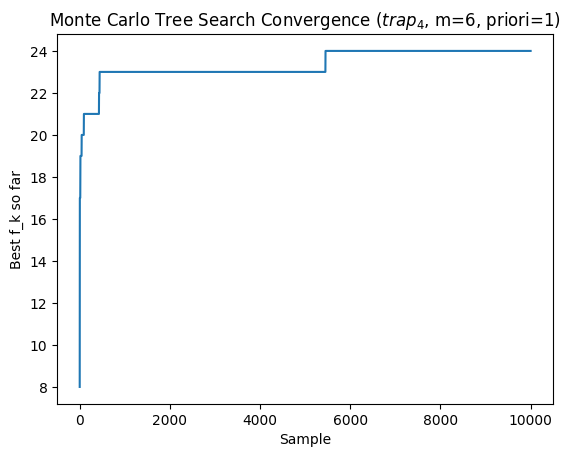

Best Value: 24
Best Solution: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Runtime: 1.406916 s


In [12]:
# Parameters
K=4
M=6
N=K*M
PRIORI = 1

# Running
start = time.perf_counter()
best_solution, best_score, hist = monte_carlo_tree_search(N, K, priori_level=PRIORI, seed=42)
end = time.perf_counter()

# Plot convergence
plt.figure()
plt.plot(hist)
plt.xlabel("Sample")
plt.ylabel("Best f_k so far")
plt.title(f"Monte Carlo Tree Search Convergence ($trap_{K}$, m={M}, priori={PRIORI})")
plt.show()

# Print results
print(f"Best Value: {best_score}")
print(f"Best Solution: {best_solution}")
print(f"Runtime: {end - start:.6f} s")

## Genetic Algorithm

**Genetic Algorithm (GA)** é uma meta­heurística baseada em processos evolutivos: mantém-se populações de soluções que “concorrerão” por sobrevida, gerando descendentes via cruzamento e mutação. Ao longo de várias gerações, a população tende a se especializar em regiões de alta qualidade, oferecendo um método eficiente para maximizar $f_k$ em $\mathrm{trap}_k$.


In [13]:
def run_ga(
    n: int,                    # tamanho do cromossomo binário
    k: int,                    # tamanho do bloco para f_k
    priori_level: int = 0,     # quantos blocos já "conhecidos" (bits iniciais fixos)
    population_size: int = 200,# número de indivíduos na população
    num_generations: int = 50, # número de gerações de evolução
    cx_prob: float = 0.8,      # probabilidade de crossover
    mut_prob: float = 0.1,     # probabilidade de mutação por bit
    seed: int = None           # semente para reproducibilidade
    ):
    
    # Remove classes antigas caso existam
    if hasattr(creator, "FitnessMax"):
        delattr(creator, "FitnessMax")
    if hasattr(creator, "Individual"):
        delattr(creator, "Individual")
        
    # Configuração do DEAP
    if seed is not None:
        np.random.seed(seed)
        
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", np.random.randint, 0, 2)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n)
    
    toolbox.register("evaluate", lambda ind: (f_k(np.array(ind), k),))
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/n)
    toolbox.register("select", tools.selTournament, tournsize=4)

    # Customizado para aplicar níveis de conhecimento
    pop = [
        creator.Individual(
            generate_item(chromo_size=n, p=k*priori_level).tolist()
        )
        for _ in range(population_size)
    ]
    
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)

    # Executa AG
    pop, logbook = algorithms.eaSimple(pop, toolbox,
                                    cxpb=cx_prob, mutpb=mut_prob,
                                    ngen=num_generations,
                                    stats=stats, halloffame=hof,
                                    verbose=False)
    
    max_fit = logbook.select("max")
    
    best = np.argmax(ind.fitness.values[0] for ind in pop)
    best_fitness = max(ind.fitness.values[0] for ind in pop)
    
    return pop[best], best_fitness, max_fit

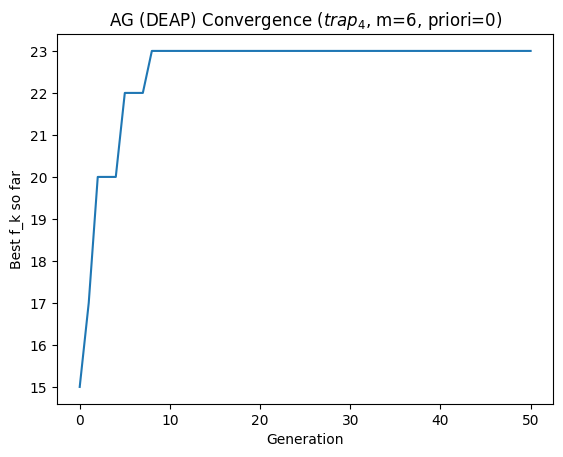

Best Value: 23.0
Best Solution: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1]
Runtime: 0.846886 s


In [14]:
# Parameters
K=4
M=6
N=K*M
PRIORI = 0

# Running
start = time.perf_counter()
best_x, best_f, gens = run_ga(N, K, priori_level=PRIORI, seed=42)
end = time.perf_counter()

# Plot convergence
plt.figure()
plt.plot(gens)
plt.xlabel("Generation")
plt.ylabel("Best f_k so far")
plt.title(f"AG (DEAP) Convergence ($trap_{K}$, m={M}, priori={PRIORI})")
plt.show()

# Print results
print(f"Best Value: {best_f}")
print(f"Best Solution: {best_x}")
print(f"Runtime: {end - start:.6f} s")

## Differential Evolution

O **Differential Evolution** é uma meta­heurística de populações reais projetada para otimização global em espaços contínuos. Ela mantém um conjunto de vetores candidatas e aplica, a cada geração, operadores simples de **mutação diferencial**, **recombinação** e **seleção** para evoluir soluções de alta qualidade.


In [15]:
def generate_binary_pop(
    n: int,            # comprimento do vetor binário
    NP: int,           # número de indivíduos a gerar
    p: int             # quantos bits iniciais fixos a 1 (priori_level * k)
) -> np.ndarray:       # matriz de forma (NP, n) com valores reais em [0,1]
    """
    Gera NP indivíduos binários de tamanho n usando priori_level,
    e converte para reais em [0,1] para DE:
      - bits 1 → uniform(0.5,1)
      - bits 0 → uniform(0,0.5)
    """
    pop_real = np.zeros((NP, n))
    for i in range(NP):
        # cria binário com priorização de 1s
        x = generate_item(n, p)
        # mapeia para real
        pop_real[i] = np.where(x==1,
                               np.random.uniform(0.5, 1.0, size=n),
                               np.random.uniform(0.0, 0.5, size=n))
    return pop_real

def run_de(
    n: int,                   # comprimento do vetor binário
    k: int,                   # tamanho do bloco para f_k
    priori_level: int = 0,    # quantos blocos já “conhecidos” (bits iniciais fixos)
    strategy: str = 'rand1bin',   # estratégia de mutação do DE
    maxiter: int = 100,           # número máximo de gerações (iterações)
    popsize: int = 50,            # fator de população: NP = popsize * n
    mutation: tuple[float,float] = (0.1, 0.5),  # parâmetros (F baixo, F alto)
    recombination: float = 0.85,   # probabilidade de recombinação
    tol: float = 0.01,             # tolerância de convergência
    seed: int = None               # semente para reproducibilidade
    ) -> tuple[np.ndarray, float, list[float]]:

    def f_k_continuous(x, k):
        # converte real → binário e soma trap_k
        bin_x = (x >= 0.5).astype(int)
        total = 0
        m = len(bin_x) // k
        for i in range(m):
            u = bin_x[i*k:(i+1)*k].sum()
            total += trap_k(int(u), k)
        return -total  # DE minimiza

    if seed is not None:
        np.random.seed(seed)

    # Population size total para DE: NP = popsize * n
    NP = popsize * n
    # Gera população inicial com priori_level
    init_pop = generate_binary_pop(n, NP, k * priori_level)

    history: list[float] = []
    def record_best(xk, convergence):
        history.append(-f_k_continuous(xk, k))
        return False

    result = differential_evolution(
        func=lambda x: f_k_continuous(x, k),
        bounds=[(0,1)] * n,
        strategy=strategy,
        maxiter=maxiter,
        popsize=popsize,
        mutation=mutation,
        recombination=recombination,
        tol=tol,
        seed=seed,
        init=init_pop,
        callback=record_best,
        polish=True,             # refinamento final
        updating='deferred',     # velocidade em paralelo
        disp=False
    )

    best_real = result.x
    best_bin = (best_real >= 0.5).astype(int)
    best_score = -result.fun

    return best_bin, best_score, history

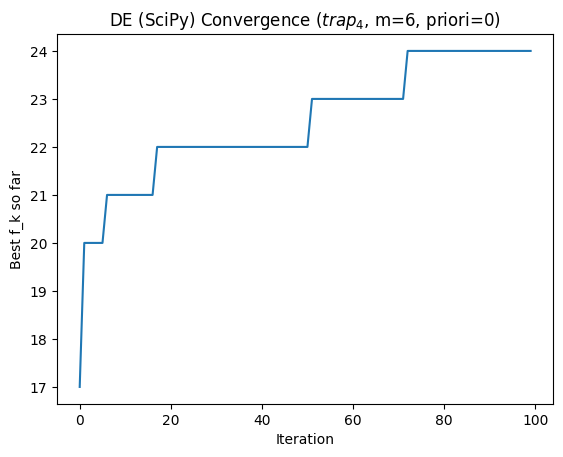

Best Value: 24.0
Best Solution: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Runtime: 22.489349 s


In [16]:
# Parameters
K=4
M=6
N=K*M
PRIORI = 0

# Running
start = time.perf_counter()
best_x, best_f, hist =  run_de(N, K, priori_level=PRIORI, seed=42)
end = time.perf_counter()

# Plot convergence
plt.figure()
plt.plot(hist)
plt.xlabel("Iteration")
plt.ylabel("Best f_k so far")
plt.title(f"DE (SciPy) Convergence ($trap_{K}$, m={M}, priori={PRIORI})")
plt.show()

# Print results
print(f"Best Value: {best_f}")
print(f"Best Solution: {best_x}")
print(f"Runtime: {end - start:.6f} s")

# Experimentos Comparativos

In [17]:
def run_experiment(k: int, m: int,
                   n_trials: int = 10,
                   threshold: int = 9
                  ) -> None:
    # Mantenha só os métodos que quiser comparar
    methods = {
        "RW": random_search,
        "MC": monte_carlo_search,
        "MCTS": monte_carlo_tree_search,
        "SA": simulated_annealing,
        "GA": run_ga,
        "DE": run_de
    }

    n_bits = k * m
    levels = list(range(m))

    # Para armazenar o nível mínimo atingido de cada método
    results = []
    # success_matrix[algo_idx, lvl_idx] = taxa de sucesso
    success_matrix = np.zeros((len(levels), len(methods)))

    for algo_idx, (algo, func) in enumerate(methods.items()):
        min_level = m  # Se não atingir o threshold em nenhum nível, fica em m
        # percorre cada nível de conhecimento
        for lvl_idx, lvl in enumerate(levels):
            succ = 0
            for _ in range(n_trials):
                x, fit, _ = func(n_bits, k, priori_level=lvl)
                # debug
                print(f"{algo}  lvl={lvl}  fit={fit}  x={list(x)}")
                if fit == n_bits:
                    succ += 1
            # preenche a matriz de sucesso
            success_rate = succ / n_trials
            success_matrix[lvl_idx, algo_idx] = success_rate

            # se já bateu o threshold, registra o nível mínimo e sai
            if succ >= threshold:
                min_level = lvl
                for tmp in range(lvl_idx, max(levels)+1):                    
                    success_matrix[tmp, algo_idx] = success_rate
                if succ == n_trials:
                    break

        results.append({
            "Metaheurística": algo,
            "Nível conhecimento": min_level
        })

    # DataFrame para o gráfico de barras
    df = pd.DataFrame(results)
    df_sorted = df.sort_values(by="Nível conhecimento", ascending=False)

    # Gráfico 1: barras
    plt.figure(figsize=(8, 6))
    sns.barplot(data=df_sorted,
                x="Metaheurística",
                y="Nível conhecimento",
                order=df_sorted["Metaheurística"])
    plt.ylim(-0.5, m - 0.5)
    plt.yticks(levels, labels=[str(l) for l in levels])
    plt.xlabel("Metaheurísticas")
    plt.ylabel("Nível mínimo de conhecimento prévio")
    plt.title(f"Conhecimento necessário para sucesso em $trap_{{{k}}}$ (m={m})")
    plt.tight_layout()
    plt.show()

    # Gráfico 2: heatmap de taxa de sucesso
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(success_matrix,
                     annot=True, fmt=".2f",
                     cmap="viridis",
                     xticklabels=list(methods.keys()),
                     yticklabels=levels)
    ax.set_xlabel("Metaheurística")
    ax.set_ylabel("Nível de conhecimento")
    ax.set_title(f"Taxa de sucesso (≥ {threshold}/{n_trials}) em $trap_{{{k}}}$, m={m}")
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()


RW  lvl=0  fit=19  x=[1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
RW  lvl=0  fit=19  x=[1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
RW  lvl=0  fit=18  x=[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1]
RW  lvl=0  fit=18  x=[1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0]
RW  lvl=0  fit=19  x=[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1]
RW  lvl=0  fit=20  x=[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
RW  lvl=0  fit=19  x=[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
RW  lvl=0  fit=20  x=[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
RW  lvl=0  fit=22  x=[1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
RW  lvl=0  fit=21  x=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
RW  lvl=1  fit=21  x=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

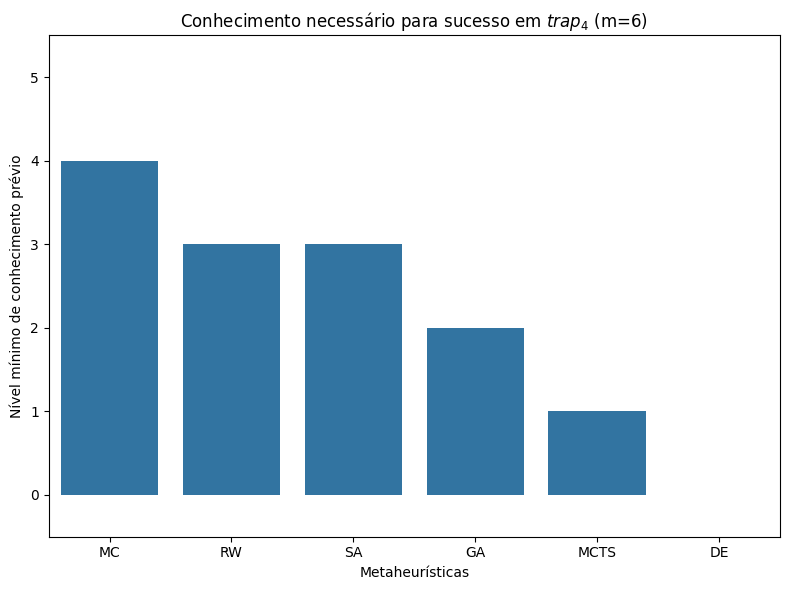

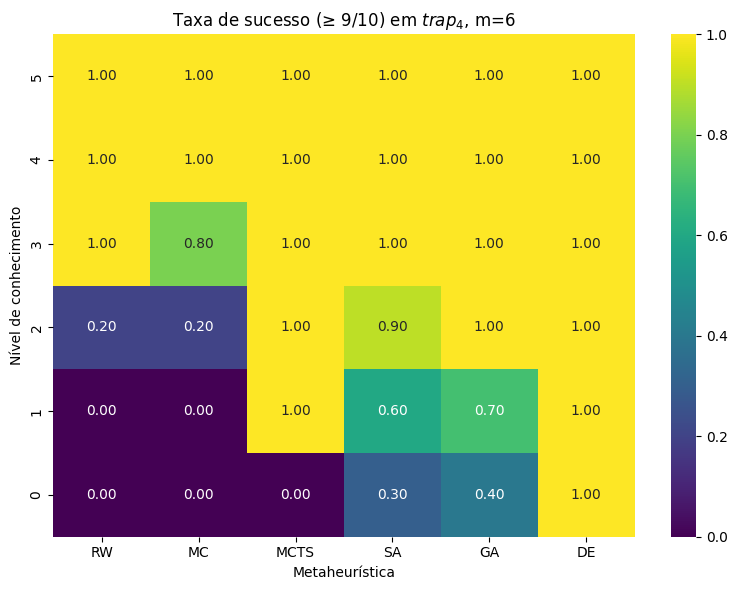

In [18]:
# K=4, M=6 => N=24
# Classificação com 90% de sucesso
run_experiment(k=4, m=6, n_trials=10, threshold=9)

RW  lvl=0  fit=17  x=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1]
RW  lvl=0  fit=15  x=[1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]
RW  lvl=0  fit=16  x=[1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
RW  lvl=0  fit=18  x=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
RW  lvl=0  fit=16  x=[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
RW  lvl=0  fit=17  x=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1]
RW  lvl=0  fit=16  x=[1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1]
RW  lvl=0  fit=15  x=[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
RW  lvl=0  fit=15  x=[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
RW  lvl=0  fit=16  x=[1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
RW  lvl=1  fit=18  x=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
RW  lvl=1  fit=16  x=[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
RW  lvl=1  fit=17  x=[1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
RW  lvl=1  f

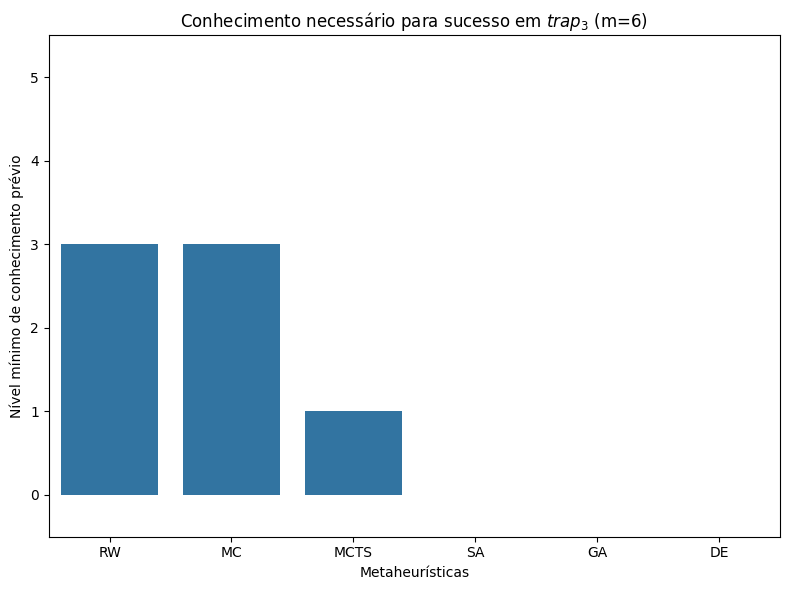

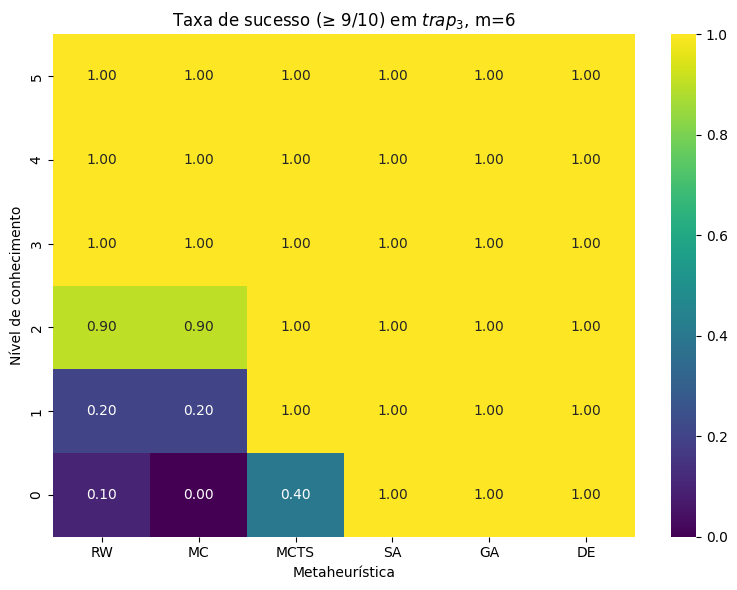

In [19]:
# K=3, M=6 => N=18
# Classificação com 90% de sucesso
run_experiment(k=3, m=6, n_trials=10, threshold=9)

RW  lvl=0  fit=24  x=[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1]
RW  lvl=0  fit=23  x=[1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
RW  lvl=0  fit=22  x=[1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
RW  lvl=0  fit=24  x=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0]
RW  lvl=0  fit=23  x=[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]
RW  lvl=0  fit=23  x=[0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
RW  lvl=0  fit=24  x=[1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]
RW  lvl=0  fit=23  x=[0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
RW  lvl=0  fit=24  x=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

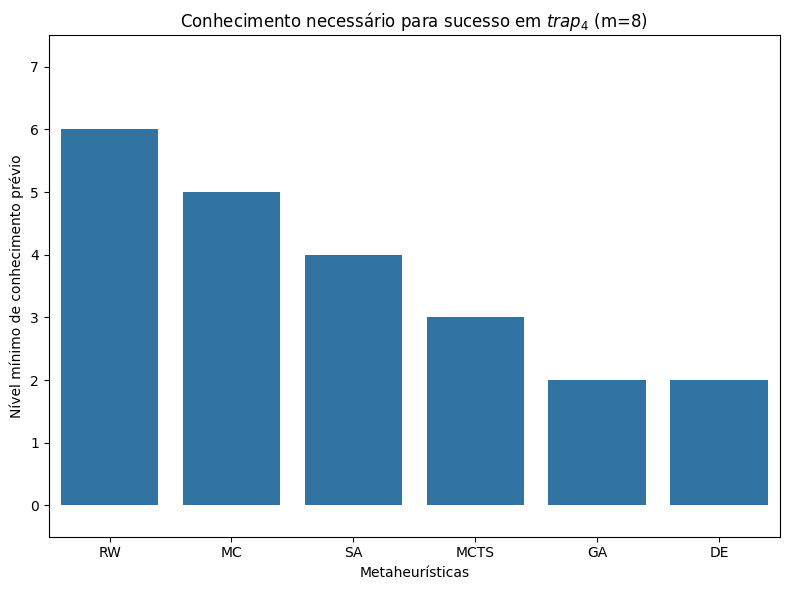

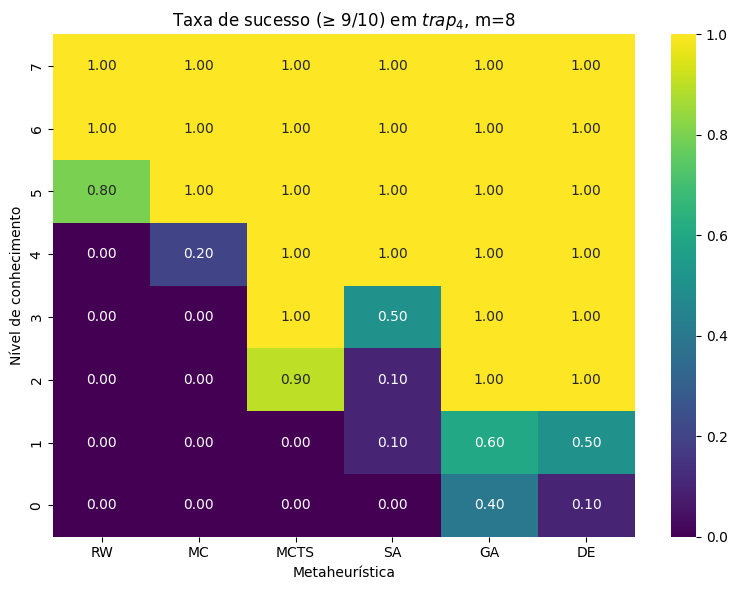

In [20]:
# K=4, M=8 => N=32
# Classificação com 90% de sucesso
run_experiment(k=4, m=8, n_trials=10, threshold=9)

RW  lvl=0  fit=23  x=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]
RW  lvl=0  fit=24  x=[0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1]
RW  lvl=0  fit=22  x=[1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0]
RW  lvl=0  fit=22  x=[0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0]
RW  lvl=0  fit=22  x=[1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1]
RW  lvl=0  fit=23  x=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0]
RW  lvl=0  fit=22  x=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
RW  lvl=0  fit=22  x=[0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]
RW  lvl=0  fit=22  x=[0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1

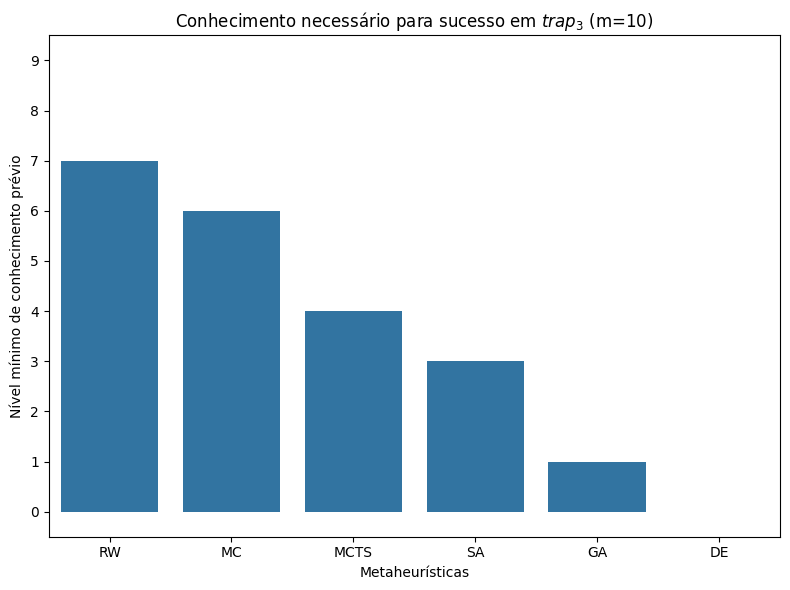

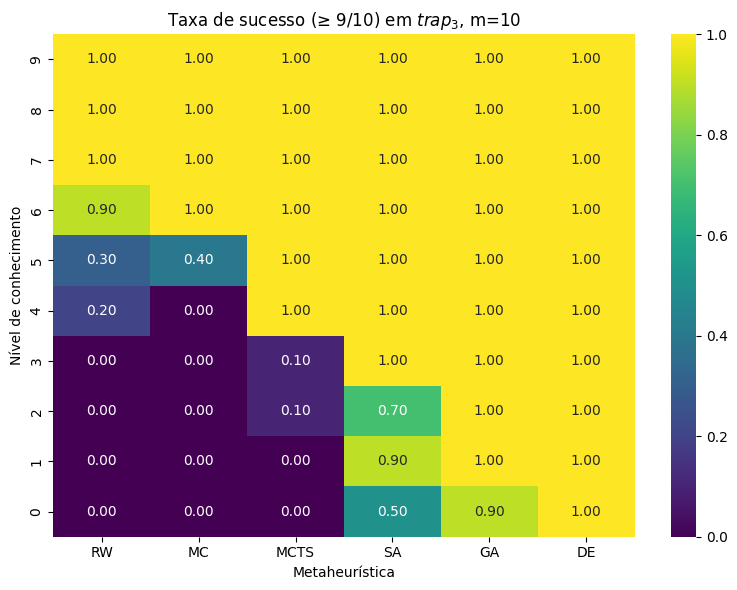

In [21]:
# K=3, M=10 => N=30
# Classificação com 90% de sucesso
run_experiment(k=3, m=10, n_trials=10, threshold=9)